In [13]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import stats as st


In [14]:
data = pd.read_csv("data/actual/100.csv")
# data = pd.read_csv("data/data_618.csv")
data = data.iloc[:,1:]
vars = list(data.columns)
n_vars = len(vars)

In [15]:
import sys
from pathlib import Path
import os
code_path = Path(os.getcwd())


In [16]:
path = code_path.joinpath('data/actual')
files = [f for f in os.listdir(path) if os.path.isfile(path.joinpath(f)) and Path(f).suffix == '.csv' ]

In [17]:
data_files = {i: pd.read_csv(path.joinpath(file)).iloc[:,1:] for i, file in enumerate(files)}

In [18]:
means = np.array([np.mean(data) for data in data_files.values()])

In [19]:
mean_n = 3
d_means = means[:,mean_n]
rest_means = means[:,[i for i in range(0,means.shape[1]) if i !=mean_n]]
rest_means.shape

(14, 5)

In [20]:
means


array([[ 1.51889753e+00,  2.34862165e-01, -2.35634503e-01,
         1.03572475e+00, -4.36549668e-03, -6.32871146e-01],
       [ 1.37387250e+00,  3.38413461e-01, -5.24534475e-01,
         1.11073841e+00,  2.45344745e-02, -6.47309518e-01],
       [ 1.47866229e+00,  0.00000000e+00, -5.61809725e-01,
         1.22672857e+00, -4.85694131e-03, -5.69630359e-01],
       [ 1.60369277e+00,  0.00000000e+00,  0.00000000e+00,
         9.71788659e-01,  5.72700511e-03, -3.41347768e-01],
       [ 1.59301240e+00,  1.90785423e-01,  1.00000000e+00,
         1.01234127e+00, -5.83424149e-02, -7.01547448e-01],
       [ 1.33611380e+00,  3.53026408e-01, -8.82506777e-01,
        -2.00000000e+00,  4.91734436e-02, -9.24995020e-01],
       [ 1.60606252e+00,  4.12924677e-01, -2.69320882e-01,
        -2.00000000e+00, -3.06791181e-02, -7.16245524e-01],
       [ 1.30000000e+00, -1.68445512e-01, -4.69079220e-01,
         1.33196422e+00,  9.07921997e-03, -7.59671360e-01],
       [ 1.38855102e+00, -8.05253573e-01, -2.400

In [21]:
colors = np.random.randint(0,255,(n_vars,3))/255

In [22]:
print(colors)

[[0.88627451 0.8        0.44705882]
 [0.40784314 0.42745098 0.14509804]
 [0.32156863 0.61960784 0.33333333]
 [0.58431373 0.31372549 0.49411765]
 [0.0745098  0.10588235 0.4       ]
 [0.47843137 0.15686275 0.88235294]]


In [23]:
# Mutual information score
import sklearn.feature_selection as sf

mutual_score = np.zeros((n_vars,n_vars))

for i in range(n_vars):
    for j in range(n_vars):
        x = np.array(data[vars[i]]).reshape((-1,1))
        y = np.array(data[vars[j]])
        mutual_score[i,j] = np.round(sf.mutual_info_regression(x,y),10)

In [24]:
[print(i,file) for i,file in enumerate(files)];

0 100.csv
1 200.csv
2 30-B=0.csv
3 30-C=0.csv
4 30-C=1.csv
5 30-D=-2.csv
6 40-D=-2.csv
7 50-A=1.3.csv
8 50-E=2.csv
9 50-F=-1.5.csv
10 50-F=2.csv
11 70-E=2-F=2.csv
12 combined_noint.csv
13 D_combined.csv


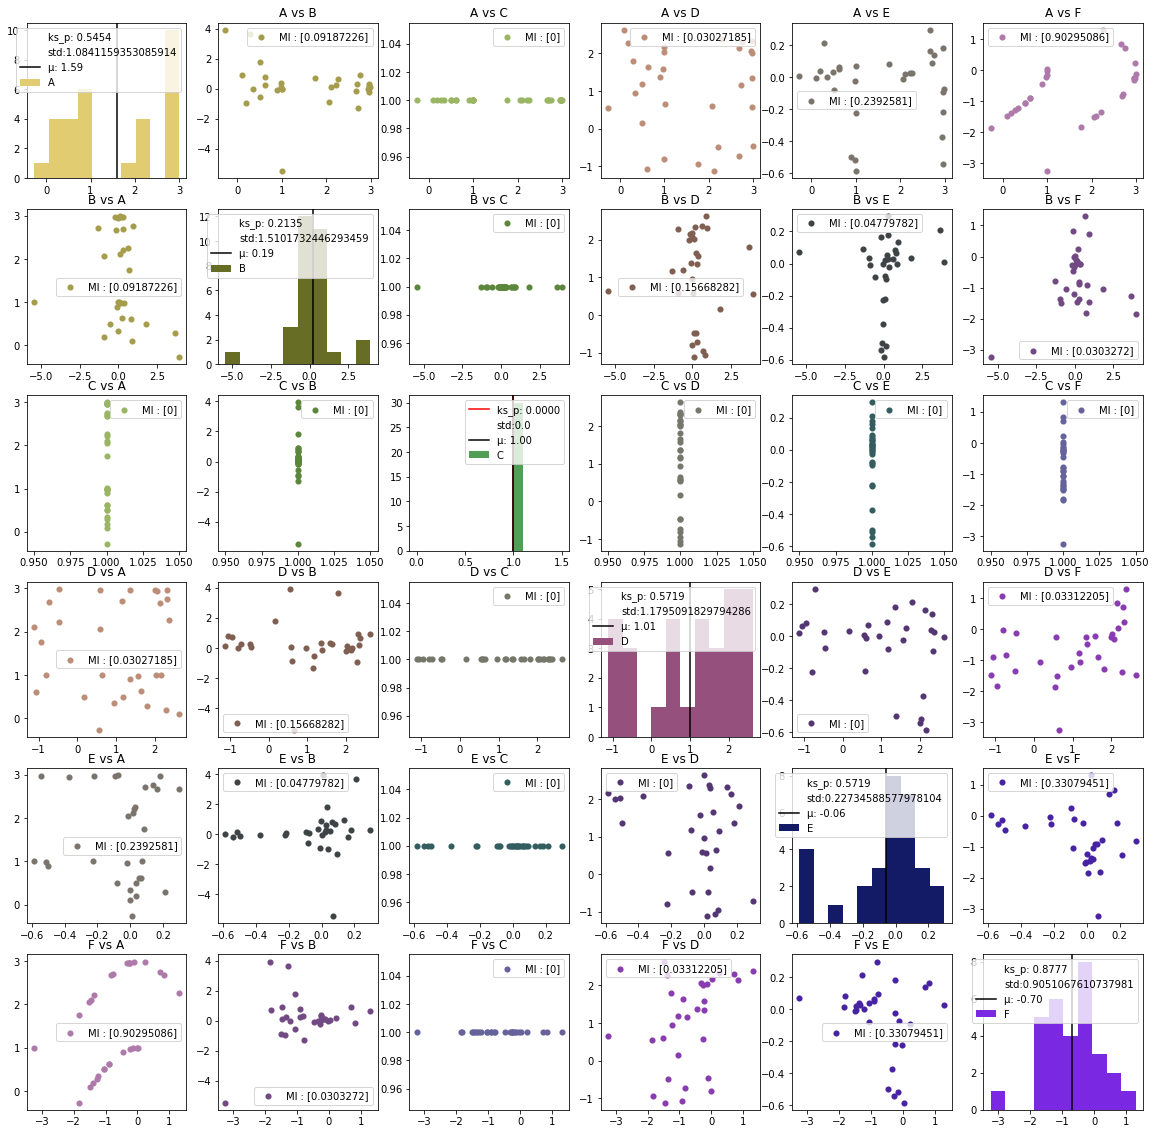

In [25]:
# Pairwise plots
def pairwise_plots(data, combarison_data = None, files = files, file_number = None):
    fig, axs = plt.subplots(n_vars,n_vars,figsize=(20,20))
    names = ["A","B","C","D","E","F"]


    for i,axs_i in enumerate(axs):
        for j,ax in enumerate(axs_i):
            if i != j:
                ax.scatter(data[vars[i]],data[vars[j]],linewidths =0.1,color=(colors[i]+colors[j])/2)
                ax.set_title(f'{vars[i]} vs {vars[j]}')
                x = np.array(data[vars[i]]).reshape((-1,1))
                y = np.array(data[vars[j]])
                mutual_score = np.round(sf.mutual_info_regression(x,y),10)
                
                ax.legend(labels=[f'MI : {mutual_score}'])
            else:
                ax.hist(data[vars[i]],color=colors[i])
    
                if combarison_data is not None:
                    # print(combarison_data.shape, data[vars[i]].shape)
                    comparison_p_value = st.ks_2samp(combarison_data[names[i]],data[vars[i]])[1]
                    alpha = 1 if comparison_p_value < 0.05 else 0
                    ax.axvline(np.mean(data[vars[i]]), color='red', alpha = alpha)
                    ax.axvline(np.std(data[vars[i]]), color='black', alpha = 0)
                    ax.axvline(np.mean(data[vars[i]]), color='black')


                    ax.legend(labels=[f'ks_p: {comparison_p_value:.4f}',f"std:{np.std(data[vars[i]])}",f'μ: {np.mean(data[vars[i]]):.2f}', vars[i]])
                else:
                    ax.axvline(np.mean(data[vars[i]]), color='black')
                    ax.legend(labels=[ f'μ: {np.mean(data[vars[i]]):.2f}', vars[i]])

                if file_number is not None:
                    fig.suptitle(f"{files[file_number][:-4]}",fontsize = 40,y=0.93)
                


pairwise_plots(data_files[4], combarison_data = data_files[12] )
# pairwise_plots(data_files[2])


In [26]:
# Normal hists
def plot_hists():
    fig, axs = plt.subplots(n_vars,figsize=(15,15))
    print(type(axs))
    for i,ax in enumerate(axs):
        ax.hist(data[vars[i]],np.arange(-30,30,1))
        ax.set_title(vars[i], fontsize = 20)

In [27]:
np.var(data['B'][data['B'] > -10])

4.654671511934819

In [28]:
# Linear Correlation
corre_matrix = np.zeros((n_vars,n_vars))
for i in range(n_vars):
    for j in range(n_vars):
        corre_matrix[i,j] = np.round(np.corrcoef(data[vars[i]]+1e-8,data[vars[j]]+1e-8)[0,1],3)
corre_matrix

array([[ 1.   , -0.128,  0.111, -0.01 ,  0.045,  0.222],
       [-0.128,  1.   ,  0.066, -0.133, -0.069, -0.188],
       [ 0.111,  0.066,  1.   ,  0.128, -0.063,  0.074],
       [-0.01 , -0.133,  0.128,  1.   ,  0.07 ,  0.186],
       [ 0.045, -0.069, -0.063,  0.07 ,  1.   , -0.041],
       [ 0.222, -0.188,  0.074,  0.186, -0.041,  1.   ]])

In [29]:
def MI(x,y,Nbins=21, names=None):
    bins = np.linspace(np.min(x),np.max(x),Nbins)
    eps=np.spacing(1)
    x_marginal = np.histogram(x,bins=bins)[0]
    x_marginal = x_marginal/x_marginal.sum()
    y_marginal = np.array(np.histogram(y,bins=bins)[0])
    y_marginal = y_marginal/y_marginal.sum()
    xy_joint = np.array(np.histogram2d(x,y,bins=(bins,bins))[0])
    xy_joint = xy_joint/xy_joint.sum()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(xy_joint.T,origin='lower')
    plt.title('joint')
    plt.subplot(1,2,2)
    plt.imshow((x_marginal[:,None]*y_marginal[None,:]).T,origin='lower')
    plt.title('product of marginals')
    mi=np.sum(xy_joint*np.log(xy_joint/(x_marginal[:,None]*y_marginal[None,:]+eps)+eps))
    if names is None:
        plt.suptitle(f'Mutual information: {mi}')
    else:
        plt.suptitle(f'Mutual information between {names[0]}, {names[1]}: {mi:.3f}')
        plt.savefig(f'./img/{names[0]}-{names[1]}.png')
    return(mi)

In [30]:
# mi = np.zeros((n_vars,n_vars))
# names = np.zeros((n_vars,n_vars)).tolist()
# for key_i, i in enumerate(vars):
#     n = names[key_i]
#     for key_j, j in enumerate(vars):
#         if j!=i:
#             mi[key_i,key_j] = sf.mutual_info_regression(x,y)(data[i], data[j])
#         n[key_j] = (i,j)

In [31]:
# fig, axs = plt.subplots(n_vars,n_vars,figsize=(15,15),dpi=200)

# for i,axs_i in enumerate(axs):
#     for j,ax in enumerate(axs_i):
#         if i != j:
#             ax.imshow(plt.imread(f'./img/{vars[i]}-{vars[j]}.png'))
#             ax.set_title(f'{vars[i]} vs {vars[j]}')

In [32]:
import sklearn.feature_selection as sf
mutal_score_M = np.zeros((n_vars,n_vars))
for i in range(n_vars):
    for j in range(n_vars):
        x = np.array(data[vars[i]]).reshape((-1,1))
        y = np.array(data[vars[j]])
        mutal_score_M[i,j] = np.round(sf.mutual_info_regression(x,y),2)

print(mutal_score_M)

[[3.34 0.11 0.   0.13 0.14 1.55]
 [0.11 3.34 0.08 0.13 0.   0.17]
 [0.   0.08 3.34 0.   0.15 0.  ]
 [0.13 0.13 0.   3.34 0.06 0.22]
 [0.14 0.   0.15 0.06 3.34 0.13]
 [1.55 0.17 0.   0.22 0.13 3.34]]


In [33]:
data_files[0]

,A,B,C,D,E,F
0,0.609014,3.061655,2.213009,-1.184504,-0.213009,-0.915980
1,0.930247,-0.335145,-1.065010,2.268498,0.065010,-0.375711
2,2.162754,-3.219556,1.997786,0.787081,0.002214,-1.407315
3,0.853078,0.023807,1.079205,1.416264,-0.079205,0.548940
4,0.561281,4.747432,-1.947666,0.557904,-0.052334,-0.974863
...,...,...,...,...,...,...
95,1.738898,1.747547,1.986365,2.201968,0.013635,-1.834960
96,2.568373,0.181462,2.019180,-0.438149,-0.019180,-0.966270
97,2.573723,-0.308505,1.752930,0.678583,0.247070,-0.959752
98,0.681775,1.301305,-1.185818,-0.536277,0.185818,-0.820610


In [34]:
[print(i,file) for i,file in enumerate(files)];

0 100.csv
1 200.csv
2 30-B=0.csv
3 30-C=0.csv
4 30-C=1.csv
5 30-D=-2.csv
6 40-D=-2.csv
7 50-A=1.3.csv
8 50-E=2.csv
9 50-F=-1.5.csv
10 50-F=2.csv
11 70-E=2-F=2.csv
12 combined_noint.csv
13 D_combined.csv


In [35]:
baseline = pd.concat((data_files[0]["D"],data_files[1]["D"]))

for i in range(len(files)):
    print(i,st.ks_2samp(baseline,data_files[i]["D"])[1].round(5))

0 0.96705
1 0.96705
2 0.48251
3 0.9411
4 0.6219
5 0.0
6 0.0
7 0.35047
8 0.8448
9 0.43808
10 0.07486
11 0.41581
12 0.96705
13 0.0


In [36]:
print(i,st.ks_2samp(data_files[2]["D"],data_files[12]["D"])[1].round(5))


13 0.37622


In [37]:
# # Prints all plots with comparison
# for i in range(len(files)):
#     pairwise_plots(data_files[i], combarison_data = data_files[12], file_number=i)


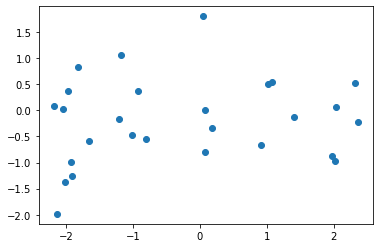

In [38]:
f = np.array(data_files[12]["F"])
c = np.array(data_files[12]["C"])

b = np.array(data_files[12]["B"])

idxs = np.where(np.logical_and(b >= 0,b <= 1))

plt.scatter(c[idxs],f[idxs])